In [1]:
from madmom.processors import SequentialProcessor
from madmom.audio.chroma import DeepChromaProcessor
from madmom.features.chords import DeepChromaChordRecognitionProcessor

dcp = DeepChromaProcessor()
decode = DeepChromaChordRecognitionProcessor()
chordrec = SequentialProcessor([dcp, decode])

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [77]:
transitions = []

base_dir = "temp_wavs"
label_map = {"0": "PN", "1": "NP", "2": "PP", "3": "NN"}

for label in ["0", "1", "2", "3"]:
    folder = os.path.join(base_dir, label)
    for fname in tqdm(os.listdir(folder), desc=f"Processing {label_map[label]}"):
        if not fname.endswith(".wav"):
            continue

        path = os.path.join(folder, fname)
        
        try:
            chords = chordrec(path)
            for i in range(len(chords) - 1):
                from_chord = chords[i][2]
                to_chord = chords[i + 1][2]
                transitions.append((from_chord, to_chord, label_map[label], fname))
        except Exception as e:
            print(f"{fname} 처리 실패: {e}")
            continue

df = pd.DataFrame(transitions, columns=["from", "to", "group", "filename"])
df.to_csv("chord_transitions.csv", index=False)

Processing NN: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


In [79]:
groups = df["group"].unique()

for g in groups:
    df_g = df[df["group"] == g]
    matrix = pd.crosstab(df_g["from"], df_g["to"])
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=False, cmap="YlGnBu")
    plt.title(f"Chord Transition Heatmap ({g})")
    plt.xlabel("To Chord")
    plt.ylabel("From Chord")
    plt.tight_layout()
    plt.savefig(f"heatmap_{g}.png")
    plt.close()

In [ ]:
stats = []

for group in ["PP", "PN", "NP", "NN"]:
    df_g = df[df["group"] == group]
    total = len(df_g)
    unique = df_g.groupby(["from", "to"]).ngroups # -> 개별 곡 unique transition -> (1차 스케일링) 해당 곡의 duration 나눔 -> emotion pair 50곡의 + -> mean
    avg_freq = total / unique if unique > 0 else 0
    diversity = unique / total if total > 0 else 0
    stats.append({
        "group": group,
        "total_transitions": total,
        "unique_transitions": unique,
        "avg_freq_per_pair": round(avg_freq, 2),
        "diversity_ratio": round(diversity, 4)
    })

stats_df = pd.DataFrame(stats)
print(stats_df)

  group  total_transitions  unique_transitions  avg_freq_per_pair  \
0    PP               9190                 360              25.53   
1    PN               9349                 344              27.18   
2    NP               8610                 386              22.31   
3    NN               8236                 408              20.19   

   diversity_ratio  
0           0.0392  
1           0.0368  
2           0.0448  
3           0.0495  


In [ ]:
df_chord = pd.read_csv("chord_transitions.csv", encoding='utf-8')
df = pd.read_csv("balanced_genre.csv", encoding='utf-8')

df = df.rename(columns={"fileName": "filename"}) 

df_chord['filename'] = df_chord['filename'].str.replace('.wav', '', regex=False).str.strip()
df['filename'] = df['filename'].str.replace('.wav', '', regex=False).str.strip()

balanced_df = df_chord[df_chord['filename'].isin(df['filename'])]

transition_stats = balanced_df.groupby('filename').agg(
    total_transition = ('from', 'count'),
    unique_transition = ('from', lambda x: len(set(zip(x, balanced_df.loc[x.index, 'to']))))
).reset_index()

df_res = df.merge(transition_stats, on='filename', how='left')

df_res['duration'] = pd.to_numeric(df_res['duration'], errors='coerce')
df_res['transition_diversity'] = df_res['unique_transition'] / df_res['total_transition']
df_res['transition_per_sec'] = df_res['total_transition'] / df_res['duration']
df_res['unique_transition_per_sec'] = df_res['unique_transition'] / df_res['duration']

df_res

,musicId,filename,title,artist,album,genre,genre_grouped,audio_arousal,audio_valence,audio_emotion_quadrant_label,...,mfcc_11_std,mfcc_12_mean,mfcc_12_std,centroid_mean,centroid_std,total_transition,unique_transition,transition_diversity,transition_per_sec,unique_transition_per_sec
0,832,Shawn Mendes - Mercy,Mercy,Shawn Mendes,Illuminate (Deluxe),Pop,Pop,0.850000,0.625000,Q1,...,8.264583,-0.980428,10.405186,1621.408414,674.715958,121,17,0.140496,0.590244,0.082927
1,563,Lady GaGa - Telephone (Feat. Beyonce),Telephone (Feat. Beyonce),Lady GaGa,2011 Grammy Nominees,Pop,Pop,0.737500,0.687500,Q1,...,9.505443,-2.104736,9.458735,2829.429468,901.440217,101,19,0.188119,0.457014,0.085973
2,566,Lady GaGa - Alejandro,Alejandro,Lady GaGa,The Fame Monster (Deluxe Edition),Pop,Pop,0.775000,0.725000,Q1,...,8.195780,-0.179934,7.872305,2614.846462,734.553745,158,16,0.101266,0.574545,0.058182
3,896,The Weeknd - A Lonely Night,A Lonely Night,The Weeknd,Starboy,R&B,Pop,0.761364,0.636364,Q1,...,7.851290,-3.028113,8.159799,2099.304427,774.934675,75,20,0.266667,0.340909,0.090909
4,753,Panic! At The Disco - Death Of A Bachelor,Death Of A Bachelor,Panic! At The Disco,Death Of A Bachelor,Pop Rock,Pop,0.762500,0.625000,Q1,...,10.027822,3.213141,8.806603,2166.200302,1006.554922,103,25,0.242718,0.490476,0.119048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,647,Maren Morris - I Could Use a Love Song,I Could Use a Love Song,Maren Morris,Hero,Country,Country,0.562500,0.612500,Q3,...,8.896393,-9.535397,10.189466,1959.776181,900.460994,48,17,0.354167,0.244898,0.086735
196,67,Bishop Briggs - River,River,Bishop Briggs,River,Alternative Rock,Rock,0.800000,0.587500,Q2,...,8.786954,-5.950349,11.063828,2263.538508,843.161577,70,19,0.271429,0.327103,0.088785
197,560,LCD Soundsystem - call the police,call the police,LCD Soundsystem,call the police / american dream,Electronic Rock,Rock,0.662500,0.512500,Q2,...,7.399622,-2.676009,6.022622,2324.335984,643.988033,34,9,0.264706,0.081146,0.021480
198,393,Gorillaz - Saturnz Barz,Saturnz Barz,Gorillaz,Humanz (Deluxe),Alternative/Electronic,EDM,0.537500,0.462500,Q3,...,7.693256,2.112334,8.791402,2206.162493,874.711017,80,39,0.487500,0.434783,0.211957


In [ ]:
summary_by_emotion = df_res.groupby('emotion_pair').agg(
    mean_total_transition=('total_transition', 'mean'),
    mean_unique_transition=('unique_transition', 'mean'),
    mean_diversity=('transition_diversity', 'mean'),
    mean_transition_per_sec=('transition_per_sec', 'mean'),
    mean_unique_per_sec=('unique_transition_per_sec', 'mean')
).reset_index()

print(summary_by_emotion)

summary_by_emotion.to_csv("chord_summary.csv", index=False)

  emotion_pair  mean_total_transition  mean_unique_transition  mean_diversity  \
0           NN                  81.84                   23.72        0.293460   
1           NP                  83.06                   19.62        0.250784   
2           PN                 101.84                   20.16        0.202721   
3           PP                  92.32                   20.18        0.234250   

   mean_transition_per_sec  mean_unique_per_sec  
0                 0.367092             0.105875  
1                 0.368742             0.088547  
2                 0.447931             0.087435  
3                 0.432850             0.096265  


In [ ]:
stats = []

for group in ["PP", "PN", "NP", "NN"]:
    df = df[df["emotion_pair"] == group]

    per_song = df.groupby("fileName")

    norm_diversities = []

    for fname, g in per_song:
        total_trans = len(g)
        unique_trans = len(g.drop_duplicates(subset=["from", "to"]))  # 유니크 전이
        if total_trans > 0:
            diversity = unique_trans / total_trans  # 정규화 다양성
            norm_diversities.append(diversity)

    group_avg_diversity = np.mean(norm_diversities)
    stats.append({
        "group": group,
        "avg_diversity_ratio": round(group_avg_diversity, 4),
        "n_songs": len(norm_diversities)
    })

stats_df = pd.DataFrame(stats)
print(stats_df)

In [44]:
from IPython.display import display

In [24]:
for group in ["PP", "PN", "NP", "NN"]:
    print(f"\n Top 10 Chord Transitions for Emotion Pair {group}")
    df_g = df[df["group"]==group]
    top_transitions = df_g.groupby(["from", "to"]).size().sort_values(ascending=False).head(10)
    display(top_transitions.reset_index(name="count"))


 Top 10 Chord Transitions for Emotion Pair PP


,from,to,count
0,C:maj,G:maj,234
1,G:maj,D:maj,202
2,F:maj,C:maj,181
3,D:maj,G:maj,163
4,A#:maj,D#:maj,157
5,D#:maj,G#:maj,156
6,C#:maj,F#:maj,148
7,D#:maj,A#:maj,147
8,A:min,G:maj,143
9,A:maj,D:maj,143



 Top 10 Chord Transitions for Emotion Pair PN


,from,to,count
0,F:maj,C:maj,215
1,C#:maj,G#:maj,199
2,G:maj,D:maj,189
3,C:maj,F:maj,189
4,C:maj,G:maj,178
5,G#:maj,D#:maj,175
6,D:maj,A:maj,166
7,E:maj,A:maj,146
8,D:maj,G:maj,142
9,G#:maj,C#:maj,137



 Top 10 Chord Transitions for Emotion Pair NP


,from,to,count
0,D#:maj,A#:maj,166
1,A#:maj,F:maj,164
2,C:maj,E:min,132
3,F:maj,A#:maj,129
4,F:maj,G:min,125
5,C#:maj,G#:maj,109
6,C:maj,F:maj,101
7,A#:maj,D#:maj,98
8,G:maj,D:maj,97
9,D:maj,G:maj,92



 Top 10 Chord Transitions for Emotion Pair NN


,from,to,count
0,D#:maj,N,138
1,N,D#:maj,131
2,D#:maj,G#:maj,101
3,A:maj,D:maj,97
4,C#:maj,D#:maj,96
5,G#:maj,D#:maj,94
6,F:maj,C:maj,94
7,D#:maj,F:min,91
8,F:min,C#:maj,84
9,A:maj,F#:min,79


In [15]:
match_df = df[df["group"].isin(["PP", "NN"])]
mismatch_df = df[df["group"].isin(["PN", "NP"])]

match_matrix = pd.crosstab(match_df["from"], match_df["to"])
mismatch_matrix = pd.crosstab(mismatch_df["from"], mismatch_df["to"])

In [ ]:
# Q1 = transition_counts["transition_count"].quantile(0.25)
# Q3 = transition_counts["transition_count"].quantile(0.75)
# IQR = Q3 - Q1
# upper_bound = Q3 + 1.5 * IQR

# filtered = transition_counts[transition_counts["transition_count"] <= upper_bound]

In [67]:
match_total_transition_counts = (
    match_df.groupby(["filename", "group"])
    .size()
    .reset_index(name="num_total_transitions")
)

mismatch_total_transition_counts = (
    mismatch_df.groupby(["filename", "group"])
    .size()
    .reset_index(name="num_total_transitions")
)

top_match = (
    match_total_transition_counts.sort_values("num_total_transitions", ascending=False)
    # .groupby("group")
    .head(10)
)

top_mismatch = (
    mismatch_total_transition_counts.sort_values("num_total_transitions", ascending=False)
    # .groupby("group")
    .head(10)
)

display(top_match)
display(top_mismatch)

,filename,group,num_total_transitions
126,Lynyrd Skynyrd - Sweet Home Alabama.wav,PP,188
169,Sean Paul - Rockabye (feat. Sean Paul & Anne-Marie).wav,PP,174
186,Train - Play That Song.wav,PP,174
188,Travis Scott - Goosebumps.wav,NN,173
157,Prince - Little Red Corvette.wav,PP,172
167,Schoolboy Q - THat Part.wav,NN,167
9,Big Sean - No Favors.wav,NN,162
35,DJ Khaled - I'm the One.wav,PP,162
4,Andy Grammer - Fresh Eyes.wav,PP,150
119,Little Mix - Touch.wav,PP,146


,filename,group,num_total_transitions
1,Adele - Hello.wav,PN,183
66,Drake - Too Good.wav,PN,173
101,Jon Bellion - All Time Low (explicit).wav,PN,162
112,Lady GaGa - Alejandro.wav,PN,158
99,Jennifer Lopez - Ain't Your Mama.wav,PN,157
193,Various Artists - DNCE - Cake By The Ocean (From ＂Grease Live!＂ Music From The Television Event).wav,NP,154
144,Panic! At The Disco - Bohemian Rhapsody.wav,PN,153
143,PLAYBOI CARTI - Woke Up Like This.wav,NP,153
110,Kygo - It Ain't Me.wav,PN,152
187,Travis Scott - Pick Up the Phone.wav,NP,151


In [68]:
match_unique_counts = (
    match_df.groupby(["group", "filename"])
    .apply(lambda g: len(set(zip(g["from"], g["to"]))))
    .reset_index(name="num_unique_transitions")
)

mismatch_unique_counts = (
    mismatch_df.groupby(["group", "filename"])
    .apply(lambda g: len(set(zip(g["from"], g["to"]))))
    .reset_index(name="num_unique_transitions")
)

top_match = (
    match_unique_counts.sort_values("num_unique_transitions", ascending=False)
    # .groupby("group")
    .head(10)
)

top_mismatch = (
    mismatch_unique_counts.sort_values("num_unique_transitions", ascending=False)
    # .groupby("group")
    .head(10)
)

display(top_match)
display(top_mismatch)

/var/folders/w9/xctc_yps7lzfqyr9lkj0gfq40000gn/T/ipykernel_1235/1540603519.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  match_df.groupby(["group", "filename"])
/var/folders/w9/xctc_yps7lzfqyr9lkj0gfq40000gn/T/ipykernel_1235/1540603519.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mismatch_df.groupby(["group", "filename"])


,group,filename,num_unique_transitions
14,NN,Dan Stevens - Evermore.wav,55
92,NN,Travis Scott - Goosebumps.wav,52
169,PP,Michael Bublé - It's Beginning To Look A Lot Like Christmas.wav,50
102,PP,Andy Williams - It's the Most Wonderful Time of the Year.wav,47
8,NN,Childish Gambino - Redbone.wav,47
103,PP,Ariana Grande - Beauty and the Beast.wav,46
28,NN,Frank Ocean - Nights.wav,45
30,NN,Future - Draco.wav,45
63,NN,Mariah Carey - I Don't.wav,45
108,PP,Bruno Mars - That's What I Like.wav,45


,group,filename,num_unique_transitions
180,PN,Panic! At The Disco - Bohemian Rhapsody.wav,70
27,NP,Drake - Since Way Back.wav,52
42,NP,J. Cole - Foldin Clothes.wav,45
92,NP,Tyga - Feel Me.wav,42
89,NP,Travis Scott - Pick Up the Phone.wav,42
0,NP,A Boogie Wit Da Hoodie - Timeless.wav,40
29,NP,Electric Light Orchestra - Mr. Blue Sky (Album Version).wav,37
41,NP,J Hus - Did You See.wav,37
21,NP,Drake - Controlla.wav,36
47,NP,Kehlani - Distraction.wav,36


total PN > PP > NP > NN 

unique NN > PP > NP > PN

diversity NN > NP > PP > PN

In [ ]:
summary_by_emotion = df.groupby('emotion_pair').agg(
    mean_total_transition=('total_transition', 'mean'),
    mean_unique_transition=('unique_transition', 'mean'),
    mean_diversity=('transition_diversity', 'mean'),
    mean_transition_per_sec=('transition_per_sec', 'mean'),
    mean_unique_per_sec=('unique_transition_per_sec', 'mean')
).reset_index()

In [69]:
emotion_pairs = df['emotion_pair'].unique()
features = ['transition_per_sec', 'unique_transition_per_sec', 'transition_diversity']

for pair in emotion_pairs:
    print(f"\n====== Emotion Pair: {pair} ======")
    df_sub = df[df['emotion_pair'] == pair]
    
    for feature in features:
        print(f"\n Top 10 by {feature}:")
        top10 = df_sub.sort_values(by=feature, ascending=False).head(10)
        display(top10[['fileName', feature]])


====== Emotion Pair: PN ======

 Top 10 by transition_per_sec:


,fileName,transition_per_sec
31,Jennifer Lopez - Ain't Your Mama,0.730233
9,Anne-Marie - Ciao Adios,0.673267
17,Drake - Too Good,0.655303
23,Adele - Hello,0.626712
18,Camila Cabello - I Have Questions,0.615385
11,Justin Bieber - . Sorry,0.592040
0,Shawn Mendes - Mercy,0.590244
2,Lady GaGa - Alejandro,0.574545
36,Machine Gun Kelly - At My Best,0.565657
49,Nevada - The Mack,0.559809



 Top 10 by unique_transition_per_sec:


,fileName,unique_transition_per_sec
46,Panic! At The Disco - Bohemian Rhapsody,0.193370
34,Tinie Tempah - Text from Your Ex,0.165049
19,Drake - Madiba Riddim,0.141463
12,Meghan Trainor - NO,0.140187
30,"Shawn Mendes - Stitches(From ""Dance Camp"" Original Motion Picture Soundtrack)",0.140097
27,Charlie Puth - Attention,0.137441
36,Machine Gun Kelly - At My Best,0.131313
15,Clean Bandit - Tears (feat. Louisa Johnson),0.130435
18,Camila Cabello - I Have Questions,0.122172
17,Drake - Too Good,0.121212



 Top 10 by transition_diversity:


,fileName,transition_diversity
46,Panic! At The Disco - Bohemian Rhapsody,0.457516
34,Tinie Tempah - Text from Your Ex,0.350515
14,Drake - Passionfruit,0.333333
20,Sabrina Carpenter - Thumbs,0.323529
12,Meghan Trainor - NO,0.315789
19,Drake - Madiba Riddim,0.311828
39,Jason Aldean - A Little More Summertime,0.300000
35,Drake - Ice Melts,0.298851
27,Charlie Puth - Attention,0.290000
3,The Weeknd - A Lonely Night,0.266667



====== Emotion Pair: NP ======

 Top 10 by transition_per_sec:


,fileName,transition_per_sec
55,Usher - No Limit [dirty],0.655022
67,Tory Lanez - LUV,0.616740
52,Demi Lovato - Body Say,0.572917
84,Rae Sremmurd - Swang,0.557692
74,Anna Kendrick - True Colors,0.530864
86,Flo Rida - My House,0.528497
85,Rae Sremmurd - Look Alive,0.513158
87,Post Malone - Go Flex,0.494444
54,Charlie Puth - One Call Away,0.489691
73,ZAYN - Still Got Time,0.481283



 Top 10 by unique_transition_per_sec:


,fileName,unique_transition_per_sec
61,Drake - One Dance,0.189655
83,MadeinTYO - Uber Everywhere,0.187845
76,Kehlani - Distraction,0.152542
51,Drake - Fire & Desire,0.147059
72,Drake - Controlla,0.146341
82,J. Cole - Foldin Clothes,0.141956
92,Dustin Lynch - Seein' Red,0.138462
71,Chris Brown - 01 Privacy,0.134529
73,ZAYN - Still Got Time,0.122995
96,Electric Light Orchestra - Mr. Blue Sky (Album Version),0.122517



 Top 10 by transition_diversity:


,fileName,transition_diversity
61,Drake - One Dance,0.523810
75,Prince - Kiss (LP Version),0.500000
83,MadeinTYO - Uber Everywhere,0.485714
92,Dustin Lynch - Seein' Red,0.409091
68,The Weeknd - Stargirl Interlude,0.400000
88,Sturgill Simpson - All Around You,0.391304
81,Trey Songz - Nobody Else But You,0.382979
76,Kehlani - Distraction,0.367347
63,Drake - Get It Together,0.355932
82,J. Cole - Foldin Clothes,0.354331



====== Emotion Pair: PP ======

 Top 10 by transition_per_sec:


,fileName,transition_per_sec
103,Train - Play That Song,0.698795
137,Flo Rida - Cake,0.681081
125,Marian Hill - Down,0.659898
101,Lady Gaga - Lady Gaga - The Cure,0.631579
107,Craig David - Ain't Giving Up,0.607595
143,"Florida Georgia Line - God, Your Mama, And Me",0.597826
102,Liam Payne - Strip That Down,0.580488
148,Jonas Blue - Mama,0.564516
120,Pitbull - Greenlight,0.561475
132,DJ Khaled - I'm the One,0.560554



 Top 10 by unique_transition_per_sec:


,fileName,unique_transition_per_sec
109,Andy Williams - It's the Most Wonderful Time of the Year,0.305195
112,Michael Bublé - It's Beginning To Look A Lot Like Christmas,0.241546
110,Bruno Mars - That's What I Like,0.217391
106,Ariana Grande - Beauty and the Beast,0.200000
102,Liam Payne - Strip That Down,0.180488
108,Chris Brown - Party,0.162896
135,Dreezy - Body,0.160173
107,Craig David - Ain't Giving Up,0.158228
123,Al Jarreau - We're In This Love Together,0.150442
125,Marian Hill - Down,0.126904



 Top 10 by transition_diversity:


,fileName,transition_diversity
112,Michael Bublé - It's Beginning To Look A Lot Like Christmas,0.588235
109,Andy Williams - It's the Most Wonderful Time of the Year,0.573171
106,Ariana Grande - Beauty and the Beast,0.541176
110,Bruno Mars - That's What I Like,0.478723
108,Chris Brown - Party,0.423529
131,Lady Gaga - A-Yo,0.410256
114,Imagine Dragons - Thunder,0.395349
133,DJ Khaled - Shining,0.372881
100,Rachel Platten - Fight Song,0.324324
135,Dreezy - Body,0.313559



====== Emotion Pair: NN ======

 Top 10 by transition_per_sec:


,fileName,transition_per_sec
185,Travis Scott - Goosebumps,0.700405
159,Alex Da Kid - Not Easy,0.570850
163,Halsey - Now Or Never,0.553488
171,Shawn Mendes - Treat You Better,0.542553
186,Kanye West - 01 Champions,0.517857
180,Mariah Carey - I Don't,0.500000
175,Maroon 5 - Cold,0.471616
188,Cole Swindell - You Should Be Here,0.470899
182,Kendrick Lamar - HUMBLE.,0.457627
199,Snakehips - Don't Leave,0.450704



 Top 10 by unique_transition_per_sec:


,fileName,unique_transition_per_sec
169,Dan Stevens - Evermore,0.282051
198,Gorillaz - Saturnz Barz,0.211957
185,Travis Scott - Goosebumps,0.210526
153,Lady Gaga - Perfect Illusion,0.205556
180,Mariah Carey - I Don't,0.175781
184,Kendrick Lamar - LOYALTY.,0.167401
152,Noah Cyrus - Make Me (Cry),0.152893
155,Frank Ocean - Nights,0.146580
167,Childish Gambino - Redbone,0.143731
158,Halsey - Not Afraid Anymore,0.140969



 Top 10 by transition_diversity:


,fileName,transition_diversity
169,Dan Stevens - Evermore,0.632184
153,Lady Gaga - Perfect Illusion,0.552239
162,Drake - Jorja Interlude,0.518519
198,Gorillaz - Saturnz Barz,0.487500
155,Frank Ocean - Nights,0.483871
187,Migos - Culture,0.444444
184,Kendrick Lamar - LOYALTY.,0.417582
179,Solange - Don't Touch My Hair,0.400000
158,Halsey - Not Afraid Anymore,0.395062
178,Katy Perry - Swish Swish,0.386667


In [3]:
from collections import defaultdict

def chord_duration_analysis(chords):
    duration_dict = defaultdict(float)
    for start, end, label in chords:
        duration_dict[label] += end - start

    sorted_items = sorted(duration_dict.items(), key=lambda x: -x[1])
    labels, durations = zip(*sorted_items)
    plt.figure(figsize=(8, 4))
    plt.bar(labels, durations)
    plt.ylabel("Total Duration (seconds)")
    plt.title("Chord Duration Analysis")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_chord_timeline(chords, total_duration=None):
    if total_duration is None:
        total_duration = max([end for (_, end, _) in chords])
    
    fig, ax = plt.subplots(figsize=(12, 2))
    for (start, end, label) in chords:
        ax.barh(0, end - start, left=start, height=0.6)
        ax.text((start + end) / 2, 0, label, ha='center', va='center', fontsize=8)

    ax.set_xlim(0, total_duration)
    ax.set_yticks([])
    ax.set_xlabel("Time (s)")
    ax.set_title("Chord Timeline")
    plt.tight_layout()
    plt.show()

In [5]:
from collections import Counter

def chord_ngram_analysis(chords, n=3, min_count=2):
    labels = [label for (_, _, label) in chords]
    ngrams = [tuple(labels[i:i+n]) for i in range(len(labels) - n + 1)]
    counts = Counter(ngrams)
    common_ngrams = {k: v for k, v in counts.items() if v >= min_count}
    sorted_ngrams = sorted(common_ngrams.items(), key=lambda x: -x[1])
    print(f"Top repeated {n}-grams (min count: {min_count}):")
    for pattern, count in sorted_ngrams:
        print(f"{pattern} -> {count} times")

In [32]:
def extract_ngram_stats(labels, n=3, min_count=2):
    ngrams = [tuple(labels[i:i+n]) for i in range(len(labels) - n + 1)]

    total = len(ngrams)
    counts = Counter(ngrams)

    common_ngrams = {k: v for k, v in counts.items() if v >= min_count}
    sorted_ngrams = sorted(common_ngrams.items(), key=lambda x: -x[1])
    pattern_strs = [f"{pattern} -> {count} times" for pattern, count in sorted_ngrams]

    unique = len(set(ngrams))
    diversity = unique / total if total > 0 else 0

    emotion = group["emotion_pair"].iloc[0]

    return total, unique, diversity, pattern_strs

df_chord = pd.read_csv("chord_transitions.csv", encoding=False)
df = pd.read_csv("res200.csv", encoding=False)
df["fileName"] = df["fileName"].astype(str) + ".wav"
balanced_df = df_chord[df_chord["fileName"].isin(df["fileName"])].copy()
balanced_df

results = []

for fname, group in balanced_df.groupby("fileName"):
    labels = list(group["to"])
    emotion = group["emotion_pair"].iloc[0]

    total, unique, diversity, top_patterns = extract_ngram_stats(labels, n=3, min_count=2)

    results.append({
        "fileName": fname,
        "emotion_pair": emotion,
        "total_ngrams": total,
        "unique_ngrams": unique,
        "diversity": diversity,
        "top_patterns": top_patterns,
    })

df_result = pd.DataFrame(results)

In [33]:
balanced_df["fileName"].nunique()

200

In [38]:
roup_avg = df_result.groupby("emotion_pair")[["total_ngrams", "unique_ngrams", "diversity"]].mean().round(4)
roup_avg

,total_ngrams,unique_ngrams,diversity
emotion_pair,,,
NN,79.84,37.08,0.4653
NP,81.06,30.04,0.3859
PN,99.84,31.96,0.3229
PP,90.32,31.62,0.3724


In [ ]:
df_result.head()

,fileName,emotion_pair,total_ngrams,unique_ngrams,diversity,top_patterns
0,Adele - Hello.wav,PN,181,21,0.116022,"[('F:min', 'C#:maj', 'G#:maj') -> 24 times, ('..."
1,Adele - Water Under The Bridge.wav,PN,108,25,0.231481,"[('G#:maj', 'F:min', 'C:min') -> 12 times, ('D..."
2,Al Jarreau - We're In This Love Together.wav,PP,107,53,0.495327,"[('C:maj', 'A:min', 'D:min') -> 11 times, ('A:..."
3,Alessia Cara - Scars To Your Beautiful.wav,PP,73,16,0.219178,"[('F:maj', 'A:min', 'F:maj') -> 19 times, ('A:..."
4,Alex Da Kid - Not Easy.wav,NN,139,24,0.172662,"[('C#:maj', 'G#:maj', 'D#:maj') -> 18 times, (..."


In [39]:
df_result.to_csv("chord_summary(ngrams).csv", index=False)

In [58]:
chords_0 = chordrec('temp_wavs/0/Justin Bieber - . Sorry.wav') # total 119 unique 20 diversity 0.168067

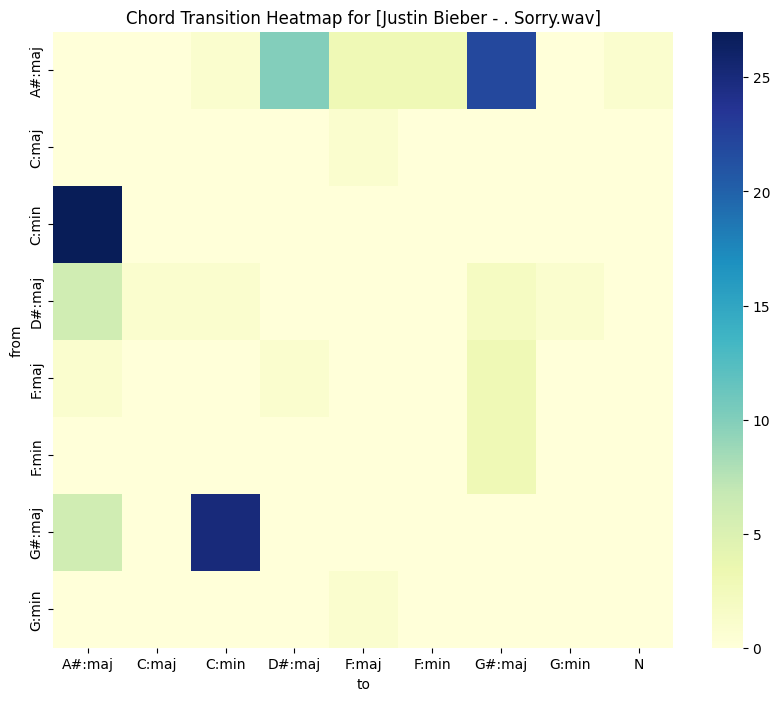

In [64]:
df_song = df_pre[df_pre["filename"] == "Justin Bieber - . Sorry.wav"]
matrix = pd.crosstab(df_song["from"], df_song["to"])

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap="YlGnBu", annot=False)
plt.title("Chord Transition Heatmap for [Justin Bieber - . Sorry.wav]")
plt.show()

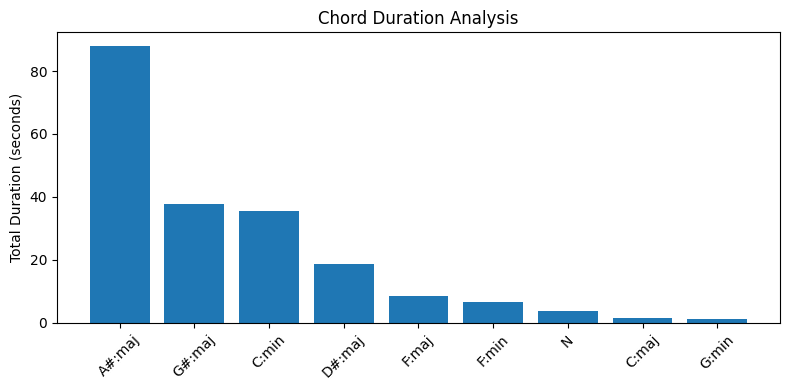

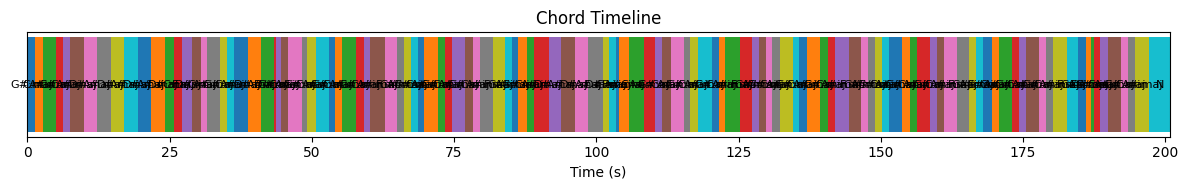

Top repeated 3-grams (min count: 2):
('G#:maj', 'C:min', 'A#:maj') -> 25 times
('A#:maj', 'G#:maj', 'C:min') -> 22 times
('C:min', 'A#:maj', 'G#:maj') -> 17 times
('A#:maj', 'D#:maj', 'A#:maj') -> 6 times
('D#:maj', 'A#:maj', 'D#:maj') -> 6 times
('G#:maj', 'A#:maj', 'G#:maj') -> 5 times
('C:min', 'A#:maj', 'D#:maj') -> 3 times
('C:min', 'A#:maj', 'F:min') -> 3 times
('A#:maj', 'F:min', 'G#:maj') -> 3 times
('F:min', 'G#:maj', 'A#:maj') -> 3 times
('C:min', 'A#:maj', 'F:maj') -> 3 times
('A#:maj', 'F:maj', 'G#:maj') -> 3 times
('F:maj', 'G#:maj', 'A#:maj') -> 3 times
('A#:maj', 'D#:maj', 'G#:maj') -> 2 times
('D#:maj', 'G#:maj', 'C:min') -> 2 times


In [61]:
chord_duration_analysis(chords_0)
plot_chord_timeline(chords_0)
chord_ngram_analysis(chords_0, n=3, min_count=2)

In [65]:
chords_2 = chordrec("temp_wavs/2/Bruno Mars - That's What I Like.wav") # total 94 unique 45 diversity 0.478723

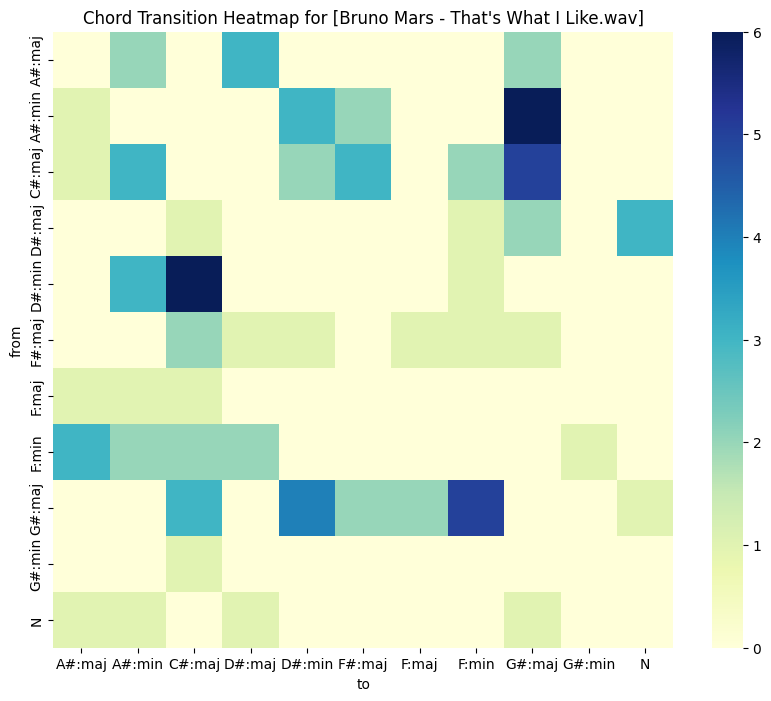

In [66]:
df_song = df_pre[df_pre["filename"] == "Bruno Mars - That's What I Like.wav"]
matrix = pd.crosstab(df_song["from"], df_song["to"])

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap="YlGnBu", annot=False)
plt.title("Chord Transition Heatmap for [Bruno Mars - That's What I Like.wav]")
plt.show()

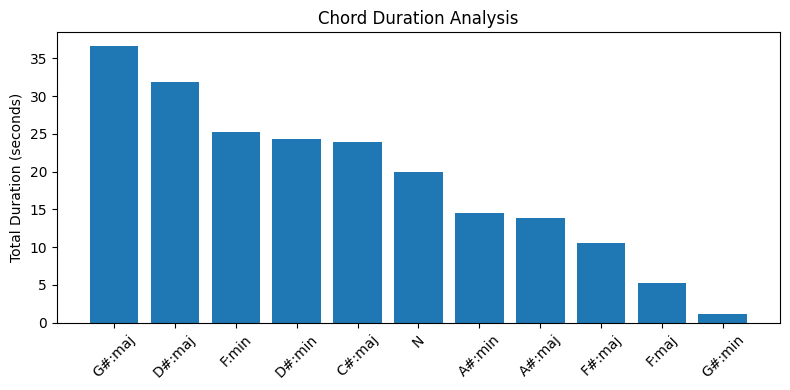

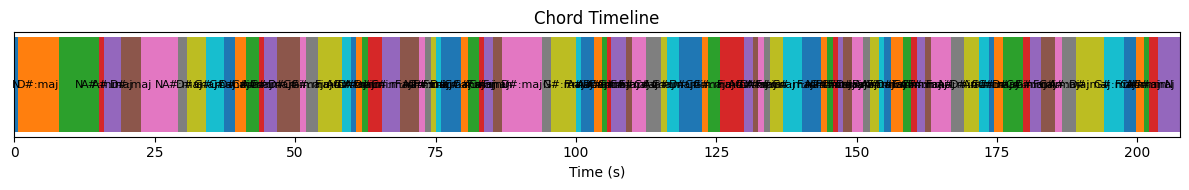

Top repeated 3-grams (min count: 2):
('D#:min', 'C#:maj', 'G#:maj') -> 4 times
('C#:maj', 'A#:min', 'G#:maj') -> 3 times
('C#:maj', 'G#:maj', 'F:min') -> 3 times
('A#:maj', 'D#:maj', 'G#:maj') -> 2 times
('G#:maj', 'C#:maj', 'D#:min') -> 2 times
('C#:maj', 'D#:min', 'C#:maj') -> 2 times
('A#:min', 'G#:maj', 'D#:min') -> 2 times
('G#:maj', 'D#:min', 'C#:maj') -> 2 times
('G#:maj', 'F:min', 'A#:maj') -> 2 times
('F:min', 'A#:maj', 'G#:maj') -> 2 times
('A#:maj', 'G#:maj', 'D#:min') -> 2 times
('G#:maj', 'D#:min', 'A#:min') -> 2 times
('A#:min', 'D#:min', 'C#:maj') -> 2 times
('F:min', 'A#:min', 'G#:maj') -> 2 times
('A#:min', 'G#:maj', 'F#:maj') -> 2 times
('G#:maj', 'F:min', 'C#:maj') -> 2 times


In [67]:
chord_duration_analysis(chords_2)
plot_chord_timeline(chords_2)
chord_ngram_analysis(chords_2, n=3, min_count=2)

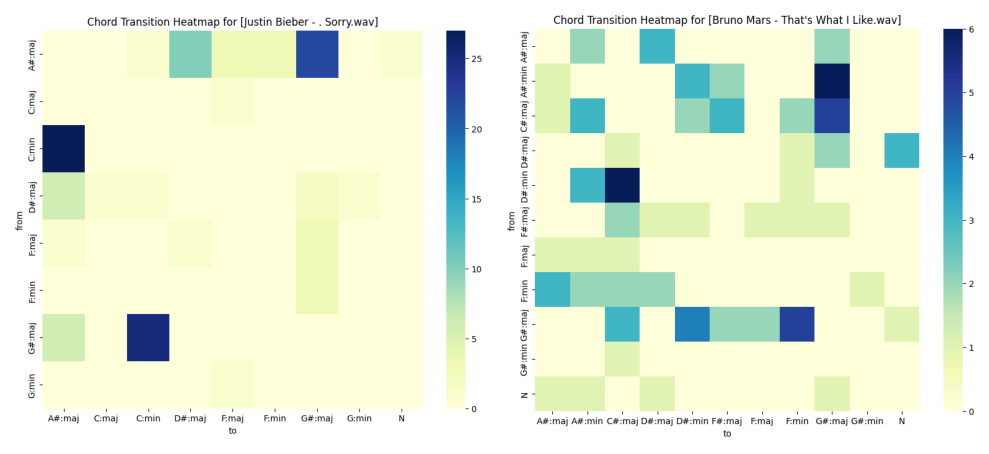

In [78]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

file_paths = ['Chord Transition Heatmap for [Justin Bieber - Sorry.wav].png', 'Chord Transition Heatmap for [Bruno Mars - Thats What I Like.wav].png']
# titles = ['[Justin Bieber - Sorry.wav]', '[Bruno Mars - Thats What I Like.wav]']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, path in enumerate(file_paths):
    img = mpimg.imread(path)
    axes[i].imshow(img)
    axes[i].axis('off')
    # axes[i].set_title(title, fontsize=12)

plt.tight_layout()
plt.show()

--Match Status

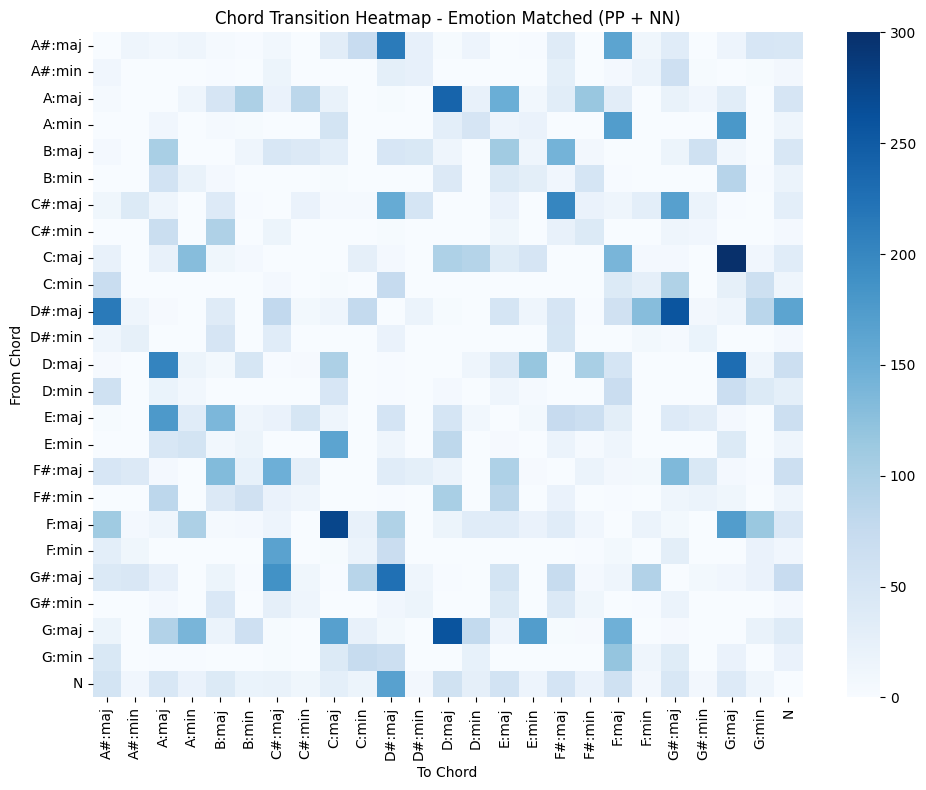

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(match_matrix, annot=False, cmap="Blues")
plt.title("Chord Transition Heatmap - Emotion Matched (PP + NN)")
plt.xlabel("To Chord")
plt.ylabel("From Chord")
plt.tight_layout()
plt.show()

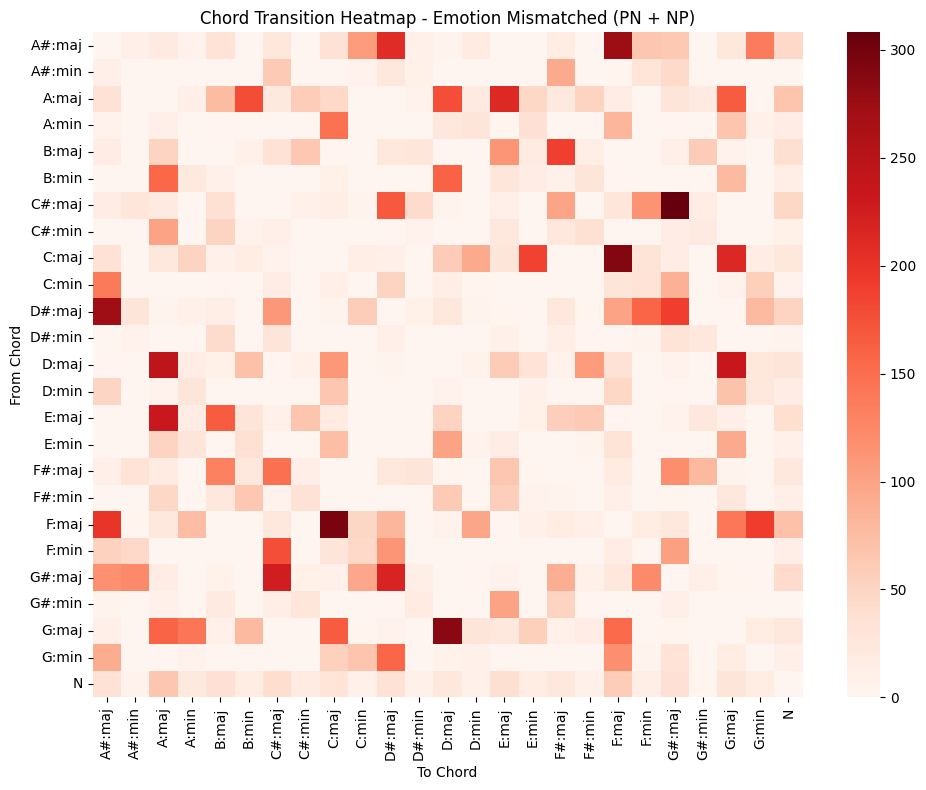

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(mismatch_matrix, annot=False, cmap="Reds")
plt.title("Chord Transition Heatmap - Emotion Mismatched (PN + NP)")
plt.xlabel("To Chord")
plt.ylabel("From Chord")
plt.tight_layout()
plt.show()